# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [2]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')
# print 'hello world'


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


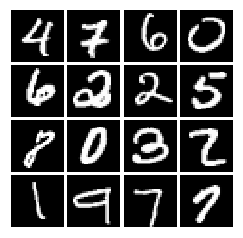

In [47]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [26]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    
    return tf.maximum(x,alpha*x)
    
    # x_pos = x * tf.cast((x > 0), dtype = 'float64')
    # x_neg = x * tf.cast((x < 0), dtype = 'float64') * alpha
    # return x_pos + x_neg
    pass


Test your leaky ReLU implementation. You should get errors < 1e-10

In [27]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [13]:
help(tf.random_uniform)

Help on function random_uniform in module tensorflow.python.ops.random_ops:

random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)
    Outputs random values from a uniform distribution.
    
    The generated values follow a uniform distribution in the range
    `[minval, maxval)`. The lower bound `minval` is included in the range, while
    the upper bound `maxval` is excluded.
    
    For floats, the default range is `[0, 1)`.  For ints, at least `maxval` must
    be specified explicitly.
    
    In the integer case, the random integers are slightly biased unless
    `maxval - minval` is an exact power of two.  The bias is small for values of
    `maxval - minval` significantly smaller than the range of the output (either
    `2**32` or `2**64`).
    
    Args:
      shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
      minval: A 0-D Tensor or Python value of type `dtype`. The lower bound on the
        range of random val

In [16]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform((batch_size, dim), minval = -1, maxval = 1)
    pass


Make sure noise is the correct shape and type:

In [17]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [20]:
help(tf.layers.dense)

Help on function dense in module tensorflow.python.layers.core:

dense(inputs, units, activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, trainable=True, name=None, reuse=None)
    Functional interface for the densely-connected layer.
    
    This layer implements the operation:
    `outputs = activation(inputs.kernel + bias)`
    Where `activation` is the activation function passed as the `activation`
    argument (if not `None`), `kernel` is a weights matrix created by the layer,
    and `bias` is a bias vector created by the layer
    (only if `use_bias` is `True`).
    
    Note: if the `inputs` tensor has a rank greater than 2, then it is
    flattened prior to the initial matrix multiply by `kernel`.
    
    Arguments:
      inputs: Tensor input.
      units: Integer or Long, dimensionality of the output space.
      activation: Activat

In [28]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        with tf.variable_scope('FullyConnected1'):
            x = tf.layers.dense(x, 256)
        with tf.variable_scope('leakyRelu1'):
            x = leaky_relu(x)
        with tf.variable_scope('FullyConnected2'):
            x = tf.layers.dense(x, 256)
        with tf.variable_scope('leakyRelu'):
            x = leaky_relu(x)
        with tf.variable_scope('FullyConnected3'):
            logits = tf.layers.dense(x, 1)
        pass
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [29]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [32]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        with tf.variable_scope('FullyConnected1'):
            x = tf.layers.dense(z, 1024)
        with tf.variable_scope('leakyRelu1'):
            x = leaky_relu(x)
        with tf.variable_scope('FullyConnected2'):
            x = tf.layers.dense(x, 1024)
        with tf.variable_scope('leakyRelu2'):
            x = leaky_relu(x)
        with tf.variable_scope('FullyConnected3'):
            x = tf.layers.dense(x, 784)
        with tf.variable_scope('TanH'):
            img = tf.tanh(x)
        pass
        return img

Test to make sure the number of parameters in the generator is correct:

In [33]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


In [36]:
help(tf.losses.sigmoid_cross_entropy)

Help on function sigmoid_cross_entropy in module tensorflow.python.ops.losses.losses_impl:

sigmoid_cross_entropy(multi_class_labels, logits, weights=1.0, label_smoothing=0, scope=None, loss_collection='losses', reduction='weighted_sum_by_nonzero_weights')
    Creates a cross-entropy loss using tf.nn.sigmoid_cross_entropy_with_logits.
    
    `weights` acts as a coefficient for the loss. If a scalar is provided,
    then the loss is simply scaled by the given value. If `weights` is a
    tensor of shape `[batch_size]`, then the loss weights apply to each
    corresponding sample.
    
    If `label_smoothing` is nonzero, smooth the labels towards 1/2:
    
        new_multiclass_labels = multiclass_labels * (1 - label_smoothing)
                                + 0.5 * label_smoothing
    
    Args:
      multi_class_labels: `[batch_size, num_classes]` target integer labels in
        `(0, 1)`.
      logits: Float `[batch_size, num_classes]` logits outputs of the network.
      weights

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [40]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    
    G_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(logits_real), logits_fake))
    D_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(logits_real), logits_real)) + \
                tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.zeros_like(logits_real), logits_fake))
    pass
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [41]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

INFO:tensorflow:logits.dtype=<dtype: 'float64'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float64'>.
INFO:tensorflow:losses.dtype=<dtype: 'float64'>.
INFO:tensorflow:logits.dtype=<dtype: 'float64'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float64'>.
INFO:tensorflow:losses.dtype=<dtype: 'float64'>.
INFO:tensorflow:logits.dtype=<dtype: 'float64'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float64'>.
INFO:tensorflow:losses.dtype=<dtype: 'float64'>.
Maximum error in d_loss: 3.97058e-09
Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [42]:
help(tf.train.AdamOptimizer)

Help on class AdamOptimizer in module tensorflow.python.training.adam:

class AdamOptimizer(tensorflow.python.training.optimizer.Optimizer)
 |  Optimizer that implements the Adam algorithm.
 |  
 |  See [Kingma et al., 2014](http://arxiv.org/abs/1412.6980)
 |  ([pdf](http://arxiv.org/pdf/1412.6980.pdf)).
 |  
 |  Method resolution order:
 |      AdamOptimizer
 |      tensorflow.python.training.optimizer.Optimizer
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
 |      Construct a new Adam optimizer.
 |      
 |      Initialization:
 |      
 |      ```
 |      m_0 <- 0 (Initialize initial 1st moment vector)
 |      v_0 <- 0 (Initialize initial 2nd moment vector)
 |      t <- 0 (Initialize timestep)
 |      ```
 |      
 |      The update rule for `variable` with gradient `g` uses an optimization
 |      described at the end of section2 of the paper:
 |      
 | 

In [43]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    pass
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [44]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [49]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x: minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

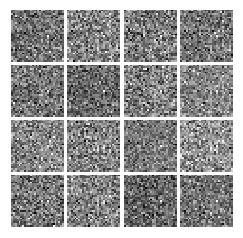


Iter: 0, D: 1.106, G:0.7326
Iter: 50, D: 1.566, G:0.7052
Iter: 100, D: 1.027, G:1.285
Iter: 150, D: 1.213, G:1.287
Iter: 200, D: 1.34, G:1.343


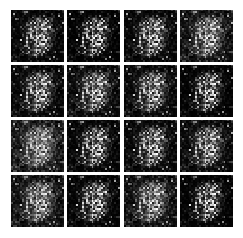


Iter: 250, D: 1.037, G:1.737
Iter: 300, D: 0.8928, G:1.356
Iter: 350, D: 1.118, G:1.285
Iter: 400, D: 0.7216, G:1.851
Iter: 450, D: 0.8593, G:1.487


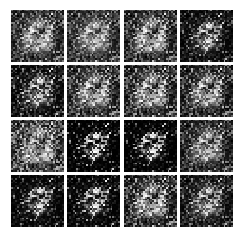


Iter: 500, D: 1.355, G:1.723
Iter: 550, D: 1.118, G:1.33
Iter: 600, D: 0.9959, G:1.222
Iter: 650, D: 1.267, G:0.882
Iter: 700, D: 1.141, G:2.638


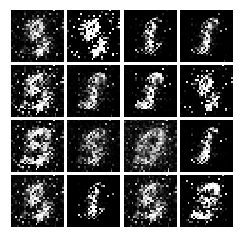


Iter: 750, D: 1.311, G:1.368
Iter: 800, D: 0.873, G:1.783
Iter: 850, D: 1.49, G:0.916
Iter: 900, D: 1.105, G:1.211
Iter: 950, D: 1.199, G:1.042


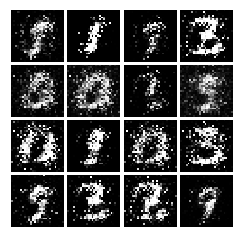


Iter: 1000, D: 1.336, G:1.164
Iter: 1050, D: 0.8387, G:1.833
Iter: 1100, D: 1.153, G:1.207
Iter: 1150, D: 1.132, G:1.233
Iter: 1200, D: 1.184, G:1.115


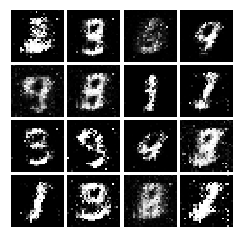


Iter: 1250, D: 1.502, G:0.4174
Iter: 1300, D: 1.218, G:1.078
Iter: 1350, D: 1.32, G:0.8449
Iter: 1400, D: 1.171, G:1.147
Iter: 1450, D: 1.238, G:0.9761


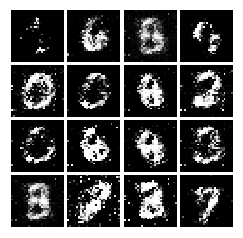


Iter: 1500, D: 1.331, G:0.9286
Iter: 1550, D: 1.21, G:0.9653
Iter: 1600, D: 1.159, G:0.9454
Iter: 1650, D: 1.297, G:0.833
Iter: 1700, D: 1.245, G:0.9382


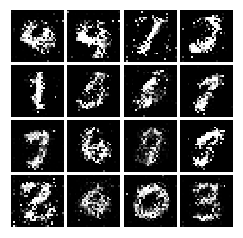


Iter: 1750, D: 1.309, G:0.8784
Iter: 1800, D: 1.333, G:1.081
Iter: 1850, D: 1.203, G:0.9941
Iter: 1900, D: 1.362, G:0.9021
Iter: 1950, D: 1.321, G:0.9236


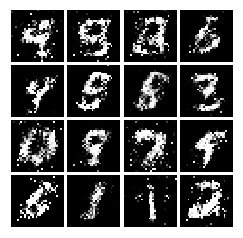


Iter: 2000, D: 1.259, G:0.9876
Iter: 2050, D: 1.319, G:0.9212
Iter: 2100, D: 1.358, G:0.8649
Iter: 2150, D: 1.218, G:1.157
Iter: 2200, D: 1.2, G:0.9234


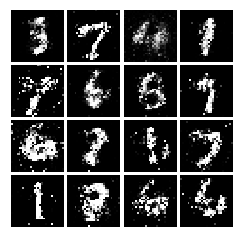


Iter: 2250, D: 1.279, G:0.8824
Iter: 2300, D: 1.308, G:0.8258
Iter: 2350, D: 1.252, G:0.8942
Iter: 2400, D: 1.288, G:0.7119
Iter: 2450, D: 1.338, G:0.7777


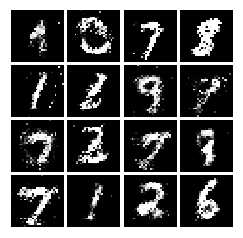


Iter: 2500, D: 1.331, G:0.8906
Iter: 2550, D: 1.322, G:0.8299
Iter: 2600, D: 1.3, G:0.9078
Iter: 2650, D: 1.302, G:0.8092
Iter: 2700, D: 1.331, G:0.8242


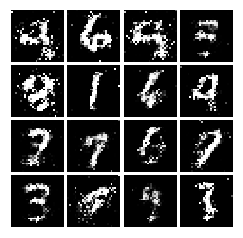


Iter: 2750, D: 1.267, G:0.8491
Iter: 2800, D: 1.287, G:0.7851
Iter: 2850, D: 1.329, G:0.8436
Iter: 2900, D: 1.344, G:0.8622
Iter: 2950, D: 1.39, G:0.8587


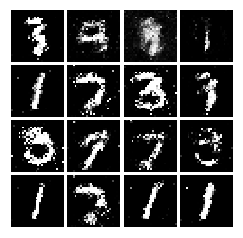


Iter: 3000, D: 1.247, G:0.8021
Iter: 3050, D: 1.394, G:0.8015
Iter: 3100, D: 1.279, G:0.8875
Iter: 3150, D: 1.357, G:0.9109
Iter: 3200, D: 1.279, G:0.8557


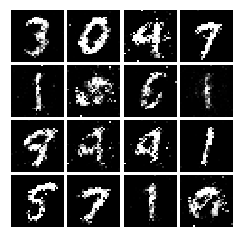


Iter: 3250, D: 1.239, G:0.7995
Iter: 3300, D: 1.323, G:0.8378
Iter: 3350, D: 1.34, G:0.881
Iter: 3400, D: 1.319, G:0.8737
Iter: 3450, D: 1.255, G:0.831


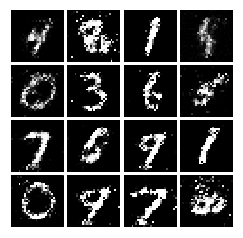


Iter: 3500, D: 1.246, G:0.9532
Iter: 3550, D: 1.232, G:0.7631
Iter: 3600, D: 1.311, G:0.8641
Iter: 3650, D: 1.32, G:0.8013
Iter: 3700, D: 1.261, G:0.9349


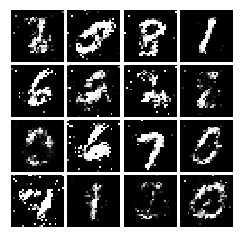


Iter: 3750, D: 1.278, G:0.7573
Iter: 3800, D: 1.301, G:0.8847
Iter: 3850, D: 1.389, G:0.8068
Iter: 3900, D: 1.354, G:0.807
Iter: 3950, D: 1.322, G:0.8309


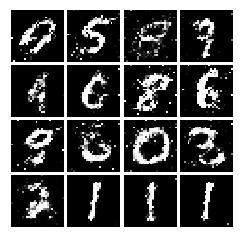


Iter: 4000, D: 1.315, G:0.757
Iter: 4050, D: 1.355, G:0.8459
Iter: 4100, D: 1.412, G:0.796
Iter: 4150, D: 1.295, G:0.8029
Iter: 4200, D: 1.313, G:0.8189


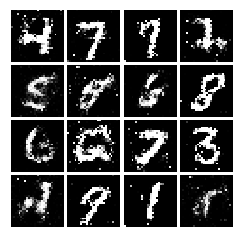


Iter: 4250, D: 1.418, G:0.8764
Final images


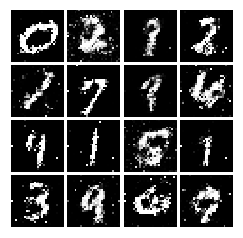

In [50]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [53]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    
    G_loss = tf.reduce_mean((score_fake - 1) ** 2) / 2
    D_loss = tf.reduce_mean((score_real - 1) ** 2) / 2 + tf.reduce_mean(score_fake ** 2) / 2
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [54]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [55]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

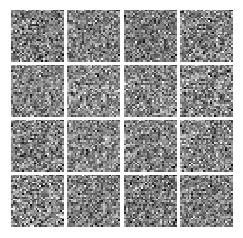


Iter: 0, D: 1.707, G:0.3955
Iter: 50, D: 0.0528, G:0.8835
Iter: 100, D: 0.09821, G:0.6529
Iter: 150, D: 0.3593, G:0.4634
Iter: 200, D: 0.2152, G:0.2579


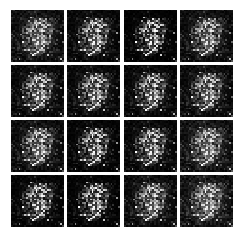


Iter: 250, D: 0.617, G:0.8184
Iter: 300, D: 0.08156, G:0.5648
Iter: 350, D: 0.2476, G:0.7407
Iter: 400, D: 0.1151, G:0.3793
Iter: 450, D: 0.1409, G:0.5288


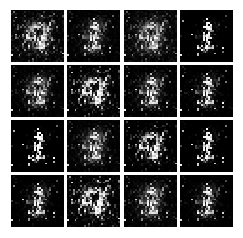


Iter: 500, D: 0.106, G:0.5067
Iter: 550, D: 0.08349, G:0.484
Iter: 600, D: 0.1129, G:0.1614
Iter: 650, D: 0.116, G:0.5768
Iter: 700, D: 0.08328, G:0.9271


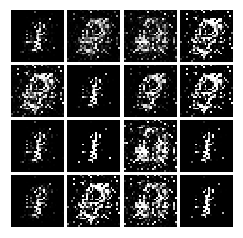


Iter: 750, D: 0.2921, G:0.5473
Iter: 800, D: 0.08769, G:0.5258
Iter: 850, D: 0.1216, G:0.4615
Iter: 900, D: 0.09275, G:0.4415
Iter: 950, D: 0.2794, G:0.4008


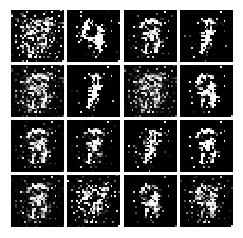


Iter: 1000, D: 0.217, G:0.0531
Iter: 1050, D: 0.09546, G:0.3791
Iter: 1100, D: 0.09799, G:0.2681
Iter: 1150, D: 1.507, G:0.07083
Iter: 1200, D: 0.2126, G:0.3924


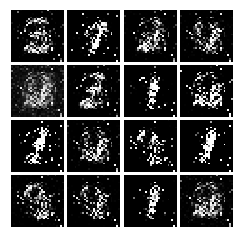


Iter: 1250, D: 0.1333, G:0.4057
Iter: 1300, D: 0.1297, G:1.177
Iter: 1350, D: 0.1066, G:0.4171
Iter: 1400, D: 0.1053, G:0.3646
Iter: 1450, D: 0.1121, G:0.4238


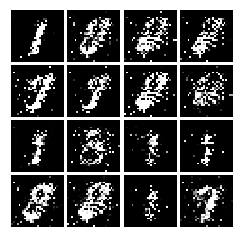


Iter: 1500, D: 0.131, G:0.345
Iter: 1550, D: 0.2245, G:0.4181
Iter: 1600, D: 0.2067, G:0.3
Iter: 1650, D: 0.1485, G:0.3046
Iter: 1700, D: 0.1483, G:0.4874


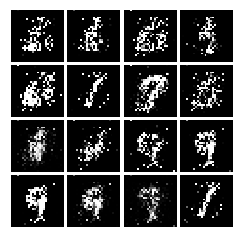


Iter: 1750, D: 0.1408, G:0.33
Iter: 1800, D: 0.1323, G:0.2152
Iter: 1850, D: 0.1455, G:0.2647
Iter: 1900, D: 0.207, G:0.2382
Iter: 1950, D: 0.1973, G:0.223


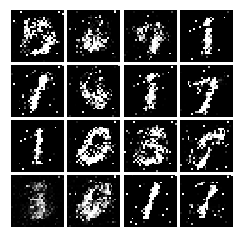


Iter: 2000, D: 0.2016, G:0.2254
Iter: 2050, D: 0.1949, G:0.2505
Iter: 2100, D: 0.2099, G:0.2038
Iter: 2150, D: 0.2034, G:0.2217
Iter: 2200, D: 0.2098, G:0.2171


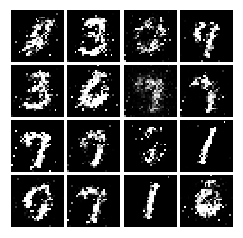


Iter: 2250, D: 0.22, G:0.2219
Iter: 2300, D: 0.1847, G:0.2069
Iter: 2350, D: 0.2057, G:0.2274
Iter: 2400, D: 0.2042, G:0.1842
Iter: 2450, D: 0.2205, G:0.2194


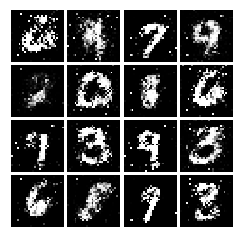


Iter: 2500, D: 0.2117, G:0.1568
Iter: 2550, D: 0.2278, G:0.1798
Iter: 2600, D: 0.2401, G:0.1723
Iter: 2650, D: 0.223, G:0.2188
Iter: 2700, D: 0.2287, G:0.1804


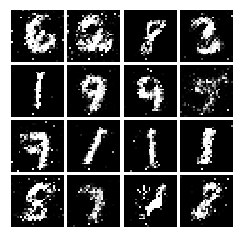


Iter: 2750, D: 0.2328, G:0.1894
Iter: 2800, D: 0.2043, G:0.1742
Iter: 2850, D: 0.21, G:0.1712
Iter: 2900, D: 0.2348, G:0.1736
Iter: 2950, D: 0.2183, G:0.2276


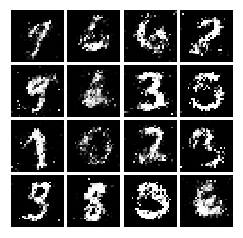


Iter: 3000, D: 0.2463, G:0.1358
Iter: 3050, D: 0.2243, G:0.1726
Iter: 3100, D: 0.2247, G:0.1916
Iter: 3150, D: 0.2466, G:0.156
Iter: 3200, D: 0.2189, G:0.1837


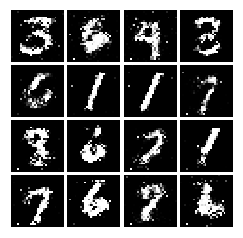


Iter: 3250, D: 0.2288, G:0.1856
Iter: 3300, D: 0.2159, G:0.2033
Iter: 3350, D: 0.1977, G:0.2074
Iter: 3400, D: 0.2204, G:0.1624
Iter: 3450, D: 0.237, G:0.1619


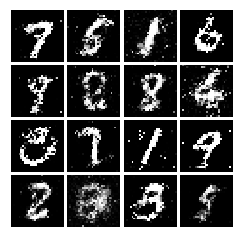


Iter: 3500, D: 0.2416, G:0.1692
Iter: 3550, D: 0.2341, G:0.1687
Iter: 3600, D: 0.251, G:0.2218
Iter: 3650, D: 0.2354, G:0.1935
Iter: 3700, D: 0.2315, G:0.1958


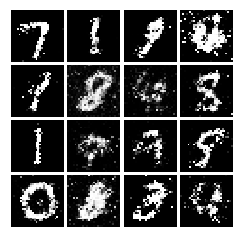


Iter: 3750, D: 0.2217, G:0.1783
Iter: 3800, D: 0.2133, G:0.1647
Iter: 3850, D: 0.2153, G:0.1703
Iter: 3900, D: 0.2201, G:0.1804
Iter: 3950, D: 0.224, G:0.1777


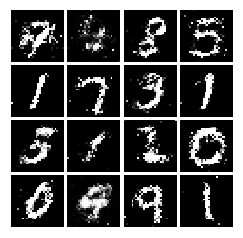


Iter: 4000, D: 0.2278, G:0.1627
Iter: 4050, D: 0.2276, G:0.189
Iter: 4100, D: 0.2131, G:0.1986
Iter: 4150, D: 0.2365, G:0.1884
Iter: 4200, D: 0.2146, G:0.1644


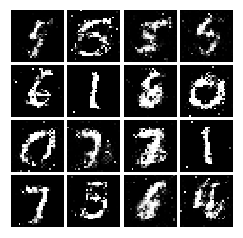


Iter: 4250, D: 0.2223, G:0.1617
Final images


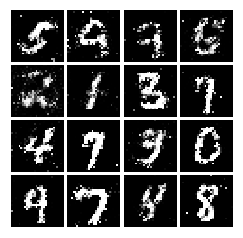

In [56]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

In [67]:
help(tf.layers)
help(tf.layers.conv2d)
help(tf.layers.max_pooling2d)
help(tf.layers.batch_normalization)
help(tf.layers.dense)
help(tf.layers.conv2d_transpose)

Help on module tensorflow.python.layers.layers in tensorflow.python.layers:

NAME
    tensorflow.python.layers.layers - This library provides a set of high-level neural networks layers.

FILE
    /home/ff/anaconda2/lib/python2.7/site-packages/tensorflow/python/layers/layers.py

DESCRIPTION
    @@dense
    @@dropout
    @@conv1d
    @@conv2d
    @@conv3d
    @@separable_conv2d
    @@conv2d_transpose
    @@conv3d_transpose
    @@average_pooling1d
    @@max_pooling1d
    @@average_pooling2d
    @@max_pooling2d
    @@average_pooling3d
    @@max_pooling3d
    @@batch_normalization


Help on function conv2d in module tensorflow.python.layers.convolutional:

conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, trainable=True, name=No

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [60]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        X = tf.reshape(x, (-1, 28, 28, 1))
        conv1 = tf.layers.conv2d(X, 32, 5)
        relu1 = leaky_relu(conv1)
        max1 = tf.layers.max_pooling2d(relu1, 2, 2)
        conv2 = tf.layers.conv2d(max1, 64, 5)
        relu2 = leaky_relu(conv2)
        max2 = tf.layers.max_pooling2d(relu2, 2, 2)
        flatten = tf.reshape(max2, (-1, 4 * 4 * 64))
        affine1 = tf.layers.dense(flatten, 4 * 4 * 64)
        relu3 = leaky_relu(affine1)
        logits = tf.layers.dense(relu3, 1)
        pass
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [76]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        affine1 = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        batch1 = tf.layers.batch_normalization(affine1, axis = 1)
        affine2 = tf.layers.dense(batch1, 7 * 7 * 128, activation = tf.nn.relu)
        batch2 = tf.layers.batch_normalization(affine2, axis = 1)
        reshaped = tf.reshape(batch2, (-1, 7, 7, 128))
        conv1 = tf.layers.conv2d_transpose(reshaped, 64, 4, (2, 2), padding = 'same')
        relu = leaky_relu(conv1)
        batch3 = tf.layers.batch_normalization(relu, axis = 1)
        conv2 = tf.layers.conv2d_transpose(batch3, 1, 4, (2, 2), padding = 'same')
        img = tf.tanh(conv2)
        pass
        return img
test_generator(6595521)

Incorrect number of parameters in generator. 6595321 instead of 6595521. Check your achitecture.


We have to recreate our network since we've changed our functions.

In [77]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

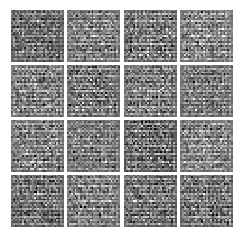


Iter: 0, D: 1.453, G:0.6572
Iter: 50, D: 0.00316, G:5.849
Iter: 100, D: 0.1975, G:3.776
Iter: 150, D: 0.2414, G:8.771
Iter: 200, D: 0.3088, G:2.334


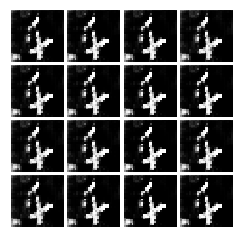


Iter: 250, D: 0.6384, G:2.411
Iter: 300, D: 0.5077, G:2.681
Iter: 350, D: 0.2947, G:3.279
Iter: 400, D: 0.8855, G:2.262
Iter: 450, D: 1.032, G:8.057


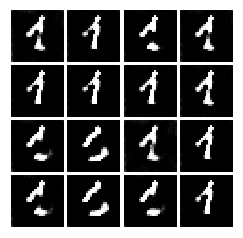


Iter: 500, D: 0.3468, G:2.432
Iter: 550, D: 0.9132, G:3.442
Iter: 600, D: 0.6282, G:2.312
Iter: 650, D: 1.001, G:1.806
Iter: 700, D: 0.664, G:5.434


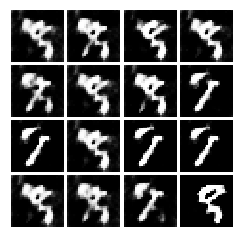


Iter: 750, D: 0.2872, G:4.167
Iter: 800, D: 0.517, G:2.008
Iter: 850, D: 0.7524, G:2.666
Iter: 900, D: 0.5115, G:3.874
Iter: 950, D: 0.4528, G:4.727


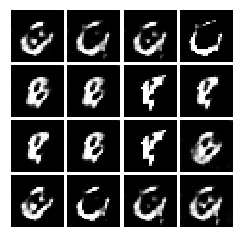


Iter: 1000, D: 1.343, G:1.782
Iter: 1050, D: 0.4225, G:3.968
Iter: 1100, D: 0.3507, G:4.951
Iter: 1150, D: 0.3055, G:5.732
Iter: 1200, D: 0.2325, G:3.941


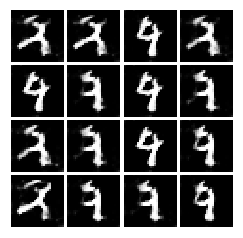


Iter: 1250, D: 0.4273, G:3.258
Iter: 1300, D: 0.6593, G:3.341
Iter: 1350, D: 0.6373, G:2.214
Iter: 1400, D: 1.268, G:14.28
Iter: 1450, D: 0.4257, G:4.883


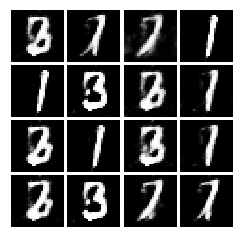


Iter: 1500, D: 0.3504, G:5.945
Iter: 1550, D: 2.431, G:10.51
Iter: 1600, D: 1.571, G:1.711
Iter: 1650, D: 0.2389, G:6.491
Iter: 1700, D: 0.1599, G:4.716


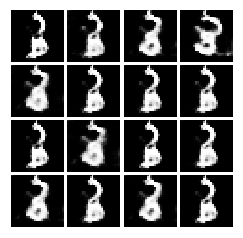


Iter: 1750, D: 0.09848, G:5.108
Iter: 1800, D: 0.6668, G:5.402
Iter: 1850, D: 1.004, G:5.761
Iter: 1900, D: 0.2113, G:3.917
Iter: 1950, D: 0.5516, G:3.927


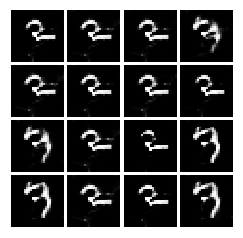


Iter: 2000, D: 0.3509, G:4.957
Iter: 2050, D: 0.2445, G:5.021
Iter: 2100, D: 0.3519, G:3.635
Final images


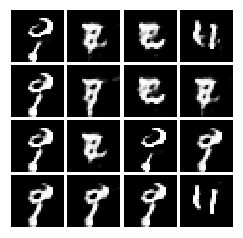

In [78]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

In [86]:
help(tf.shape)

Help on function shape in module tensorflow.python.ops.array_ops:

shape(input, name=None, out_type=tf.int32)
    Returns the shape of a tensor.
    
    This operation returns a 1-D integer tensor representing the shape of `input`.
    
    For example:
    
    ```python
    # 't' is [[[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]]]
    shape(t) ==> [2, 2, 3]
    ```
    
    Args:
      input: A `Tensor` or `SparseTensor`.
      name: A name for the operation (optional).
      out_type: (Optional) The specified output type of the operation
        (`int32` or `int64`). Defaults to `tf.int32`.
    
    Returns:
      A `Tensor` of type `out_type`.



# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [90]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        reshaped = tf.reshape(x, (-1, 28, 28, 1))
        conv1 = tf.layers.conv2d(reshaped, 64, 4, 2)
        relu1 = leaky_relu(conv1)
        conv2 = tf.layers.conv2d(relu1, 128, 4, 2)
        relu2 = leaky_relu(conv2)
        batch = tf.layers.batch_normalization(relu2, axis = 1)
        flatten = tf.reshape(batch, (-1, 128 * 5 * 5))
        affine1 = tf.layers.dense(flatten, 1024)
        relu3 = leaky_relu(affine1)
        logits = tf.layers.dense(relu3, 1)
        pass
        return logits
test_discriminator(3411649)

Incorrect number of parameters in discriminator. 3411157 instead of 3411649. Check your achitecture.


In [91]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [92]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = 0
    x_hat = 0

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = None

    grad_norm = None
    grad_pen = None



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

AttributeError: 'NoneType' object has no attribute 'dtype'

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)